In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import xgboost as xgb
# from xgboost import XGBRegressor
from fitter import Fitter
# from scipy import signal
from pandas.plotting import autocorrelation_plot
from pmdarima.arima import ADFTest
# # from sklearn import preprocessing
# from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
# from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
sns.set_style('darkgrid')
# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt
# from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# from statsmodels.tools.tools import add_constant
# from sklearn.metrics import accuracy_score,confusion_matrix
# from pandas.plotting import lag_plot
# from pmdarima.arima import auto_arima
%matplotlib inline
# import shap

In [3]:
os.chdir('G:/My Drive/To_Do/MMM/Raw_Hain_Data/Pivot')

In [4]:
smd_pivot = pd.read_csv('smd_pivot.csv')
# ts_pivot = pd.read_csv('ts_pivot.csv')
# ct = pd.read_csv('ct_spend.csv') # need information on revenue or impressions
# dm_pivot = pd.read_csv('dm_pivot_2.csv')

This summary of different stats for the original model can be compared to the .describe()
of the imputed dataset to see how it changed (or didn't change).

In [5]:
df = smd_pivot
df.describe()

,CustomerEvent_I,CustomerEvent_S,DigitalCoupon_I,DigitalCoupon_S,DigitalDemo_I,Digital_Demo_S,Digital_Incentive_I,Digital_Incentive_S,Digital_Media_I,Digital_Media_S,...,Retailer_Media_S,Sampling_I,Sampling_S,Signage_I,Signage_S,Social_Influence_I,Social_Influence_S,Social_Media_I,Social_Media_S,revenue
count,1.0,1.0,1.300000e+01,13.000000,1.0,1.0,4.000000e+00,4.000000,9.000000e+00,9.000000,...,6.000000,2.000000e+00,2.000000,6.000000e+00,6.000000,3.000000e+00,3.000000,7.000000e+00,7.000000,1.110000e+02
mean,1856871.0,4654.0,1.834327e+06,8417.846154,6751832.0,5600.0,7.572664e+06,58702.250000,4.447724e+06,43758.444444,...,12190.000000,3.744294e+06,56957.000000,2.566799e+06,25443.666667,1.363045e+06,17265.000000,1.790524e+06,6188.571429,5.850931e+06
std,NaN,NaN,2.626268e+06,16503.136237,NaN,NaN,8.797130e+06,89371.294297,8.096367e+06,72324.927862,...,15508.884383,4.899252e+06,56630.767892,2.843491e+06,35926.879918,2.083951e+06,12195.345506,2.159233e+06,11456.977348,7.912031e+06
min,1856871.0,4654.0,4.800000e+04,0.000000,6751832.0,5600.0,2.564457e+06,3812.000000,1.000000e+04,0.000000,...,66.000000,2.800000e+05,16913.000000,1.197420e+05,737.000000,1.197660e+05,3227.000000,8.247500e+04,0.000000,0.000000e+00
25%,1856871.0,4654.0,1.619430e+05,998.000000,6751832.0,5600.0,2.576301e+06,4700.750000,9.556900e+04,340.000000,...,2555.750000,2.012147e+06,36935.000000,3.941528e+05,1848.750000,1.601010e+05,13274.000000,1.227410e+05,646.500000,1.237130e+05
50%,1856871.0,4654.0,3.392340e+05,2295.000000,6751832.0,5600.0,3.512196e+06,19998.500000,1.196510e+05,9555.000000,...,3360.000000,3.744294e+06,56957.000000,1.603884e+06,3882.500000,2.004360e+05,23321.000000,7.813100e+05,1610.000000,1.973042e+06
75%,1856871.0,4654.0,1.734811e+06,5000.000000,6751832.0,5600.0,8.508559e+06,74000.000000,2.200629e+06,27691.000000,...,22639.750000,5.476442e+06,76979.000000,4.029772e+06,49446.250000,1.984685e+06,24284.000000,2.787400e+06,4275.000000,8.210528e+06
max,1856871.0,4654.0,7.679896e+06,58811.000000,6751832.0,5600.0,2.070181e+07,191000.000000,2.021154e+07,205192.000000,...,35000.000000,7.208589e+06,97001.000000,7.243973e+06,78355.000000,3.768934e+06,25247.000000,5.849598e+06,31867.000000,3.770181e+07


In [60]:
def missing_values(df):
    names = [var for var in df.columns]
    missing_count = df[names].isnull().sum()
    var_count = np.array(df[names].isnull().sum() * 100/ len(df)).round(2)
    missing = pd.DataFrame(index=names)
    missing["Count Missing"] = missing_count
    missing["Percent Missing"] = var_count
    print(missing)


def dickey_fuller(df):
    adf_test = ADFTest(alpha = .05)
    print('A value of True means that the ADFTest null hypothesis that the time series is non-stationary is correct.')
    result = adf_test.should_diff(df['revenue'])
    return result


def unique(df):
    percent_unique = np.array(100 * df.nunique()/len(df.index)).round(2)
    count_unique = df.nunique()
    names = [var for var in df.columns]
    unique_df = pd.DataFrame(index=names)
    unique_df["Count Unique"] = count_unique
    unique_df["Percent Unique"] = percent_unique
    print(unique_df)


def corr_plot(df):
    corr_temp = df.drop(['DATE'], axis=1)
    corr_names = corr_temp.columns.tolist()
    temp_df = df[corr_names]
    corr = temp_df.corr(method="pearson").round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(18, 18))
    cmap = sns.diverging_palette(250, 1, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
                vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def distributions(df):
    for var in temp_df:
        dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']
        dist_test = temp_df[var].dropna()
        dist_test = dist_test.values
        f = Fitter(dist_test, distributions=dist_list, timeout=60)
        f.fit()
        print(var)
        # print(f.summary(plot=False))
        print(f.get_best(method='sumsquare_error'))


def summary(df):
    print(missing_values(df))
    print(unique(df))
    corr_plot(df)

This summary gives us information on missing values, the number of unique values, and correlation before imputation.
In some cases, it suggests that columns of entirely missing data might be dropped right away. Once again, it is valuable
to compare to the imputed result.

                     Count Missing  Percent Missing
DATE                             0             0.00
CustomerEvent_I                110            99.10
CustomerEvent_S                110            99.10
DigitalCoupon_I                 98            88.29
DigitalCoupon_S                 98            88.29
DigitalDemo_I                  110            99.10
Digital_Demo_S                 110            99.10
Digital_Incentive_I            107            96.40
Digital_Incentive_S            107            96.40
Digital_Media_I                102            91.89
Digital_Media_S                102            91.89
Direct_Mail_I                  110            99.10
Direct_Mail_S                  110            99.10
Email_Blast_I                  107            96.40
Email_Blast_S                  107            96.40
IRC_I                          108            97.30
IRC_S                          108            97.30
LCM_I                          104            93.69
LCM_S       

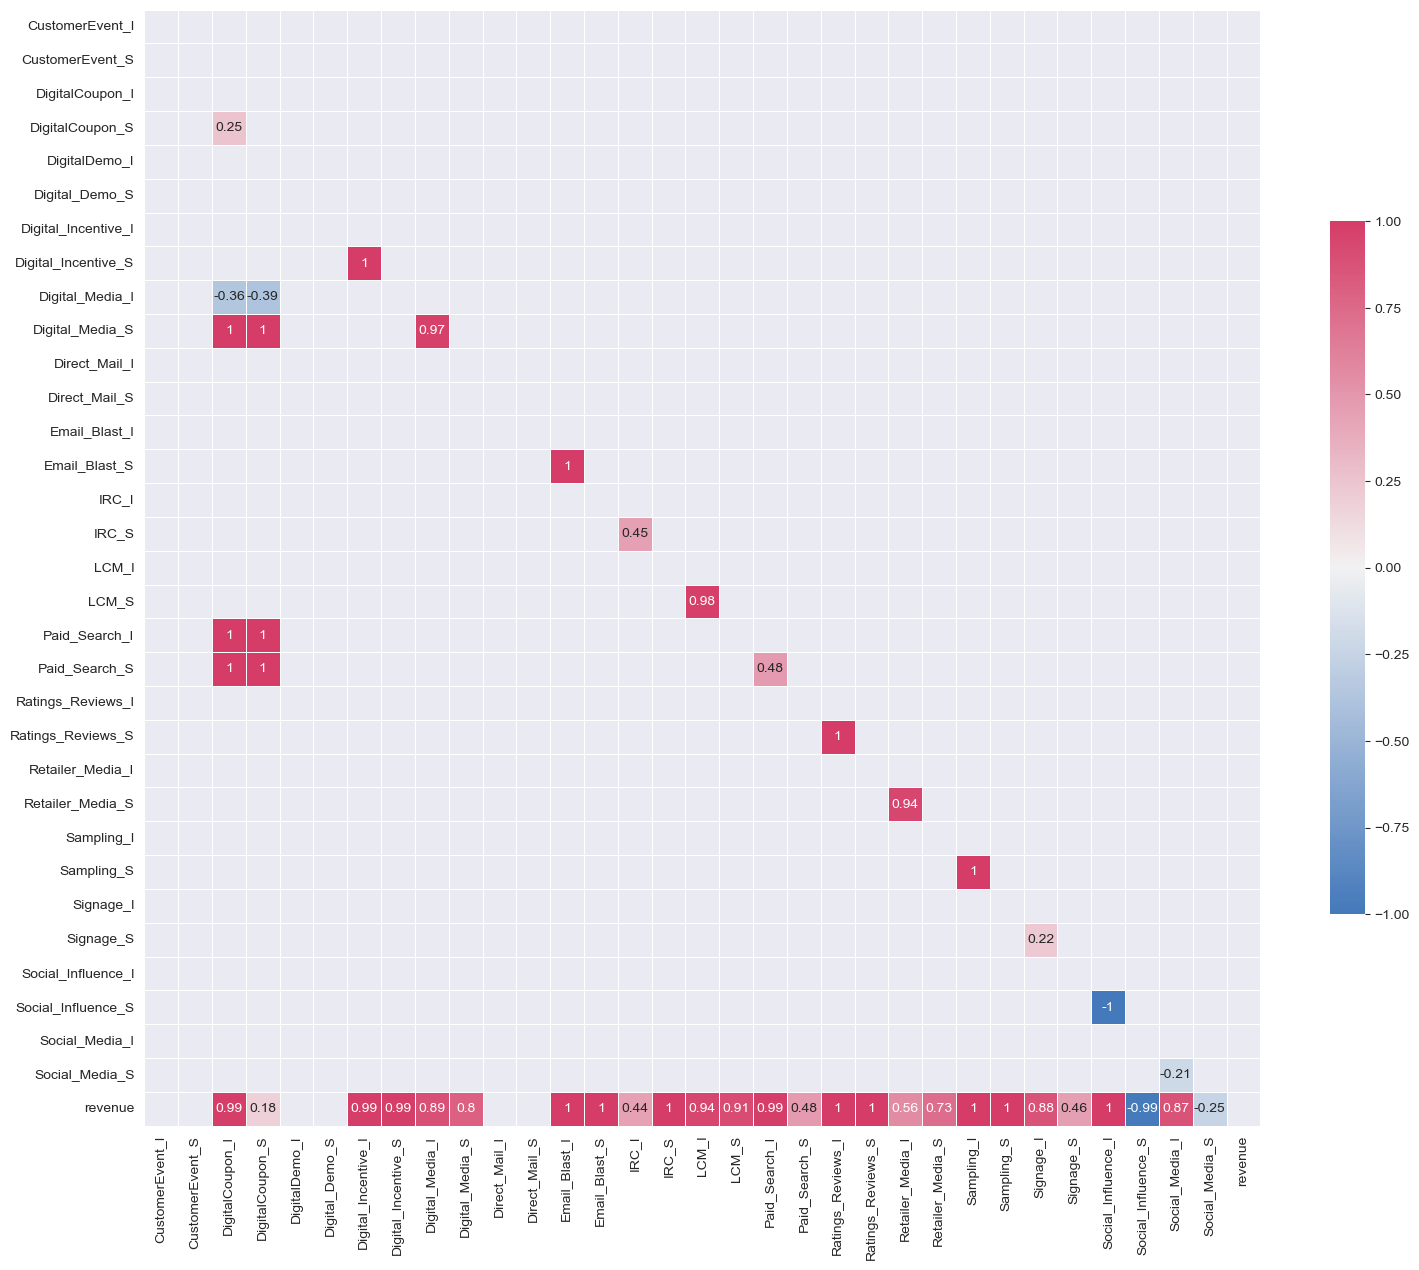

In [7]:
summary(df)

Helps drop variables when necessary and creates a few variables that will be used later.

                     Count Missing  Percent Missing
DATE                             0             0.00
CustomerEvent_I                110            99.10
CustomerEvent_S                110            99.10
DigitalCoupon_I                 98            88.29
DigitalCoupon_S                 99            89.19
DigitalDemo_I                  110            99.10
Digital_Demo_S                 110            99.10
Digital_Incentive_I            107            96.40
Digital_Incentive_S            107            96.40
Digital_Media_I                102            91.89
Digital_Media_S                103            92.79
Direct_Mail_I                  110            99.10
Direct_Mail_S                  110            99.10
Email_Blast_I                  108            97.30
Email_Blast_S                  108            97.30
IRC_I                          108            97.30
IRC_S                          109            98.20
LCM_I                          104            93.69
LCM_S       

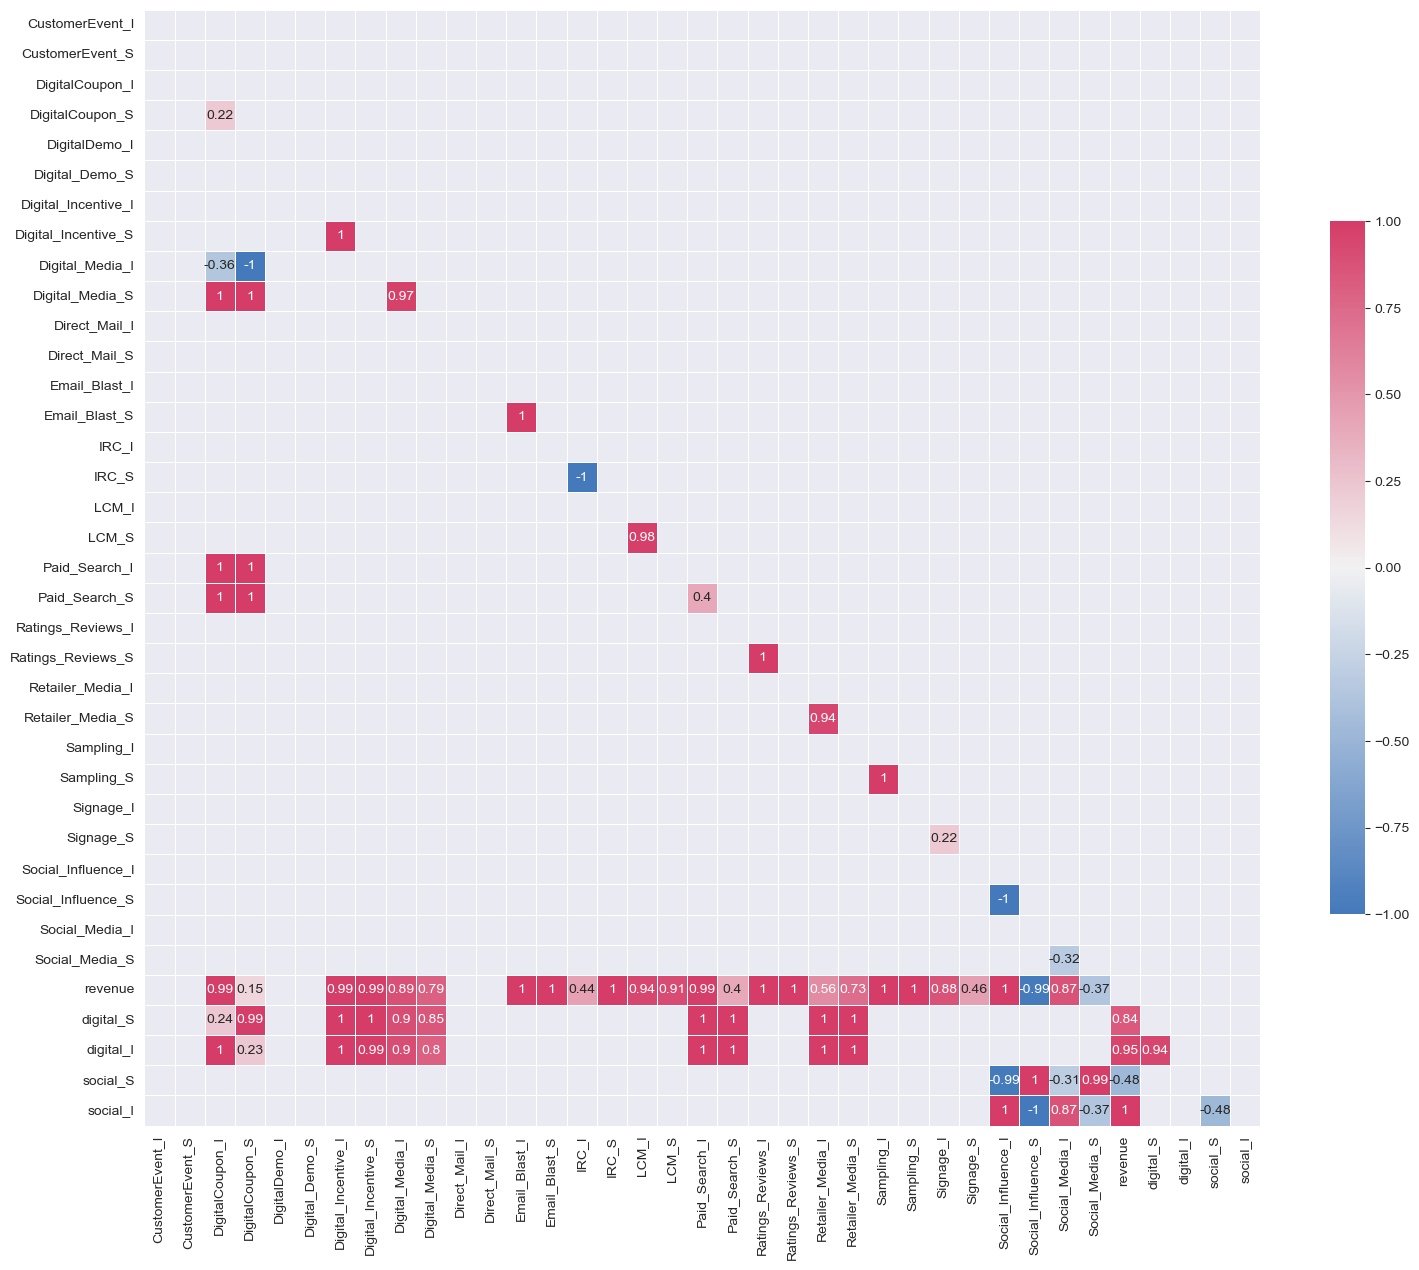

In [15]:
df_zero = df.fillna(0)

df_zero['digital_S'] = df_zero['DigitalCoupon_S'] + df_zero['Digital_Demo_S'] + df_zero['Digital_Incentive_S'] + df_zero['Digital_Media_S']
df_zero['digital_I'] = df_zero['DigitalCoupon_I'] + df_zero['DigitalDemo_I'] + df_zero['Digital_Incentive_I'] + df_zero['Digital_Media_I']
df_zero['social_S'] =df_zero['Social_Media_S'] + df_zero['Social_Influence_S']
df_zero['social_I'] =df_zero['Social_Media_I'] + df_zero['Social_Influence_I']
df = df_zero.replace(0, np.nan)
summary(df)

               Count Missing  Percent Missing
DATE                       0             0.00
revenue                    8             7.21
Paid_Search_S             57            51.35
social_S                 103            92.79
digital_S                 89            80.18
Paid_Search_I             56            50.45
social_I                 102            91.89
digital_I                 88            79.28
None
               Count Unique  Percent Unique
DATE                    111          100.00
revenue                 102           91.89
Paid_Search_S            54           48.65
social_S                  8            7.21
digital_S                22           19.82
Paid_Search_I            55           49.55
social_I                  9            8.11
digital_I                23           20.72
None


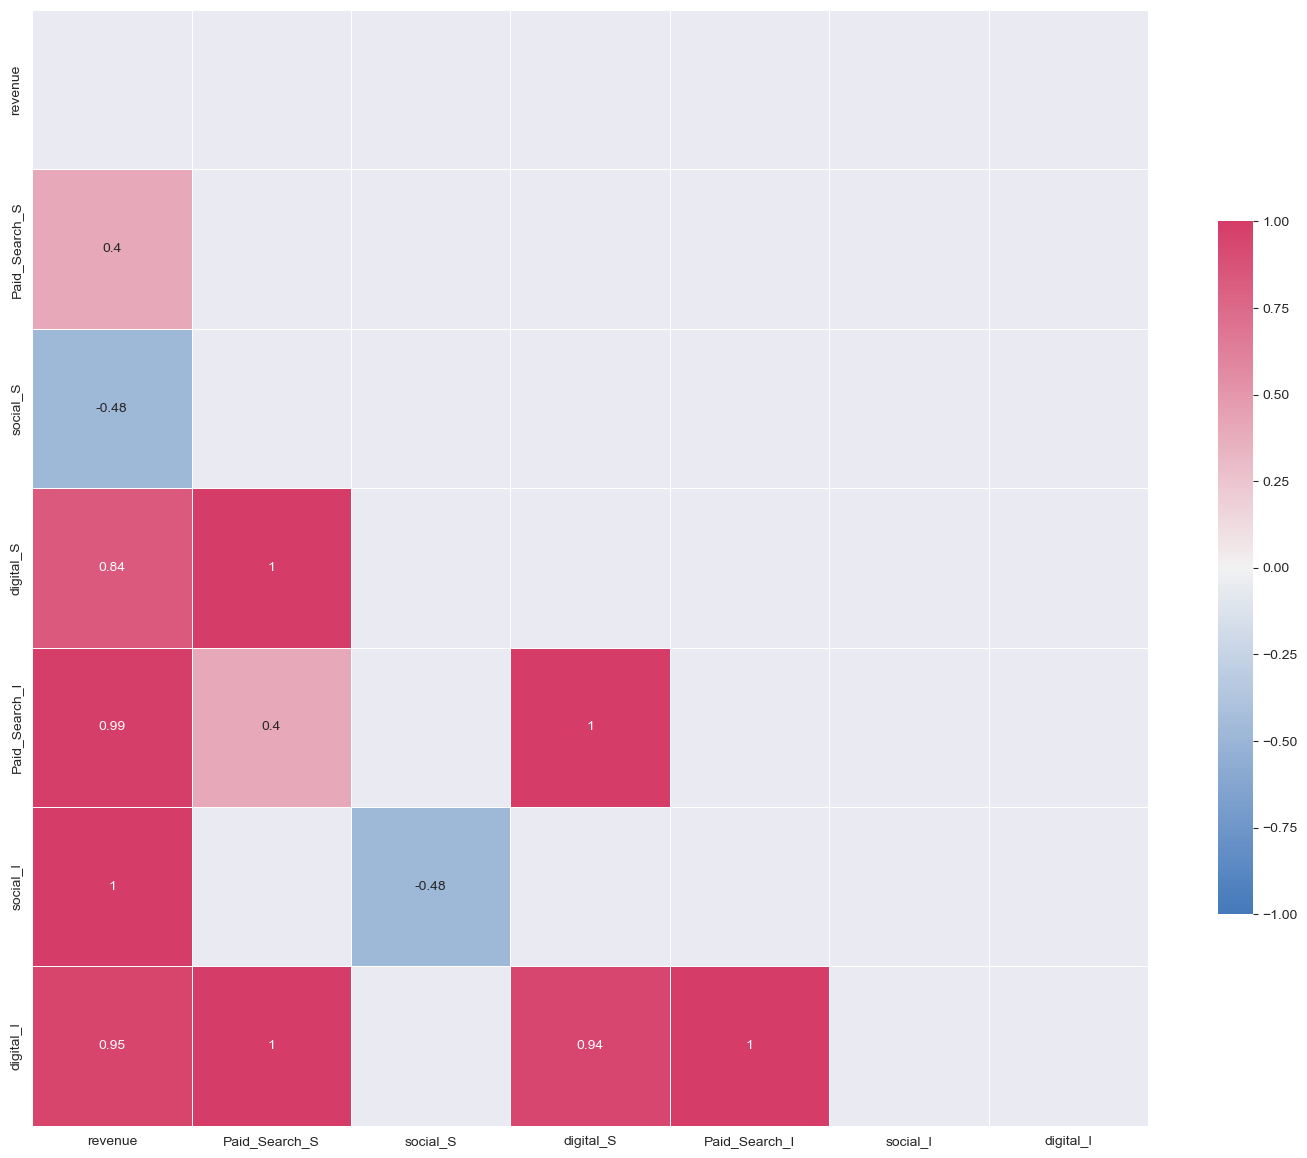

In [17]:
# df = df.drop([], axis=1)
df = df[['DATE', 'revenue', 'Paid_Search_S', 'social_S', 'digital_S', 'Paid_Search_I', 'social_I', 'digital_I']]
temp_week = df['DATE']
corr_temp = df.drop(['DATE'], axis=1)
corr_names = corr_temp.columns.tolist()
summary(df)

Will be repeating this test to see how the distributions change after imputation

In [ ]:
temp_df = df.drop(['DATE'], axis=1)
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in temp_df:
    dist_test = temp_df[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

In [19]:
df.describe()

,revenue,Paid_Search_S,social_S,digital_S,Paid_Search_I,social_I,digital_I
count,1.030000e+02,54.000000,8.000000,22.000000,5.500000e+01,9.000000e+00,2.300000e+01
mean,6.305372e+06,18752.277778,11889.375000,33803.045455,8.040464e+06,1.846978e+06,4.387751e+06
std,8.038442e+06,16492.799510,12687.955537,77740.728856,7.783102e+06,2.609076e+06,8.523414e+06
min,3.040000e+02,8.000000,531.000000,113.000000,3.040000e+02,8.247500e+04,1.000000e+04
25%,3.275055e+05,4880.750000,3190.500000,1605.750000,1.145726e+06,1.197660e+05,1.549715e+05
50%,2.580249e+06,17652.000000,4693.500000,4718.500000,6.478631e+06,2.004360e+05,1.265754e+06
75%,8.789520e+06,27509.000000,23802.500000,18761.250000,1.319306e+07,2.857155e+06,4.353186e+06
max,3.770181e+07,75000.000000,31867.000000,316000.000000,2.940230e+07,6.486580e+06,3.770181e+07


The KNNImputer uses a method similar to regression and nearby non-missing values to fill in missing values.
The number of neighboring values can be adjusted to find better fits for the missing values.

In [35]:
knn_df_names = tuple(corr_names)
knn_temp = df[corr_names]
df_knn = knn_temp.filter(knn_df_names, axis=1).copy()

In [36]:
# # KNN Imputation
knn_df_names = tuple(corr_names)
knn_temp = df[corr_names]
df_knn = knn_temp.filter(knn_df_names, axis=1).copy()
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

In [37]:
# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
df_knn_imputed = pd.DataFrame(scaler.inverse_transform(df_knn_imputed), columns=df_knn.columns)
KNN_imputation = pd.concat([df_knn_imputed, temp_week], axis=1)

Multiple Imputation by Chained Equations (MICE) uses iterations of Bayesian Ridge Linear models
and takes the averages of their results to determine the imputed values. Compared to most other methods,
it performs better with extremely sparse data.

In [47]:
mice_names = tuple(corr_names)
mice_temp = df[corr_names]
df_mice = mice_temp.filter(mice_names, axis=1).copy()
mice_estimator = IterativeImputer(estimator=linear_model.BayesianRidge(), sample_posterior=True, max_iter=40,
                                n_nearest_features=10, imputation_order='random')
df_mice_imputed = pd.DataFrame(mice_estimator.fit_transform(df_mice), columns=df_mice.columns)
df_mice_imputed = df_mice_imputed.apply(lambda x: x.abs(), axis=1)
imputed_mice = pd.concat([df_mice_imputed, temp_week], axis=1)

In [117]:
imputed_mice.to_csv('smd_mice_2.csv', encoding='utf-8', index=False)
KNN_imputation.to_csv('smd_KNN_2.csv', encoding='utf-8', index=False)

### Post Hoc Tests

Of particular interest here is noticing the differences between the means and the standard deviations

In [50]:
KNN_imputation.describe()

,revenue,Paid_Search_S,social_S,digital_S,Paid_Search_I,social_I,digital_I
count,1.110000e+02,111.000000,111.000000,111.000000,1.110000e+02,1.110000e+02,1.110000e+02
mean,6.305372e+06,17535.201495,10629.503871,33054.302929,6.126315e+06,2.273035e+06,4.424830e+06
std,7.740618e+06,14450.164957,5469.119699,52430.830816,7.085564e+06,1.978055e+06,5.958376e+06
min,3.040000e+02,8.000000,531.000000,113.000000,3.040000e+02,8.247500e+04,1.000000e+04
25%,4.094295e+05,5341.519188,6404.467447,4333.144809,2.123436e+05,2.352265e+05,3.128716e+05
50%,3.088383e+06,18065.000000,9374.605651,11090.331113,3.088383e+06,1.846978e+06,2.564457e+06
75%,8.210528e+06,23108.008421,14310.837347,33803.045455,8.264094e+06,3.889677e+06,5.249256e+06
max,3.770181e+07,75000.000000,31867.000000,316000.000000,2.940230e+07,6.486580e+06,3.770181e+07


In [49]:
df.describe()

,revenue,Paid_Search_S,social_S,digital_S,Paid_Search_I,social_I,digital_I
count,1.030000e+02,54.000000,8.000000,22.000000,5.500000e+01,9.000000e+00,2.300000e+01
mean,6.305372e+06,18752.277778,11889.375000,33803.045455,8.040464e+06,1.846978e+06,4.387751e+06
std,8.038442e+06,16492.799510,12687.955537,77740.728856,7.783102e+06,2.609076e+06,8.523414e+06
min,3.040000e+02,8.000000,531.000000,113.000000,3.040000e+02,8.247500e+04,1.000000e+04
25%,3.275055e+05,4880.750000,3190.500000,1605.750000,1.145726e+06,1.197660e+05,1.549715e+05
50%,2.580249e+06,17652.000000,4693.500000,4718.500000,6.478631e+06,2.004360e+05,1.265754e+06
75%,8.789520e+06,27509.000000,23802.500000,18761.250000,1.319306e+07,2.857155e+06,4.353186e+06
max,3.770181e+07,75000.000000,31867.000000,316000.000000,2.940230e+07,6.486580e+06,3.770181e+07


In [51]:
imputed_mice.describe()

,revenue,Paid_Search_S,social_S,digital_S,Paid_Search_I,social_I,digital_I
count,1.110000e+02,111.000000,111.000000,111.000000,1.110000e+02,1.110000e+02,1.110000e+02
mean,6.257170e+06,20087.789579,18052.376887,47931.813008,6.328839e+06,6.259079e+06,5.660705e+06
std,7.803877e+06,16361.024586,18218.480857,58841.312212,7.588173e+06,7.817615e+06,7.162012e+06
min,3.040000e+02,8.000000,336.291295,93.251277,3.040000e+02,1.261150e+03,1.000000e+04
25%,4.094295e+05,6718.500388,7911.793598,7330.858380,9.959970e+05,4.045807e+05,9.590252e+05
50%,2.857155e+06,18065.000000,13699.554661,23858.750335,3.348280e+06,2.805881e+06,2.436459e+06
75%,9.272396e+06,27566.314708,23860.108005,67144.494771,8.860899e+06,9.292449e+06,7.855662e+06
max,3.770181e+07,80072.355713,140346.538398,316000.000000,3.813657e+07,3.766973e+07,3.770181e+07


The Augmented Dickey-Fuller function tests if a time series needs differencing,
which returns True, or if the time series is stationary. It also implies that
if the test returns True, it is not a random walk and the imputation is somewhat
decent, at the minimum.

In [54]:
dickey_fuller(imputed_mice)

A value of True means that the ADFTest null hypothesis that the time series is non-stationary is correct.


(0.07967209380967512, True)

In [55]:
dickey_fuller(KNN_imputation)

A value of True means that the ADFTest null hypothesis that the time series is non-stationary is correct.


(0.12070974573299278, True)

Autocorrelation is another test for time series that tests if the current date's value is correlated
with previous observations. If the blue line is above the dotted line, this suggests the time series
is autocorrelated as well as the time series not being random.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

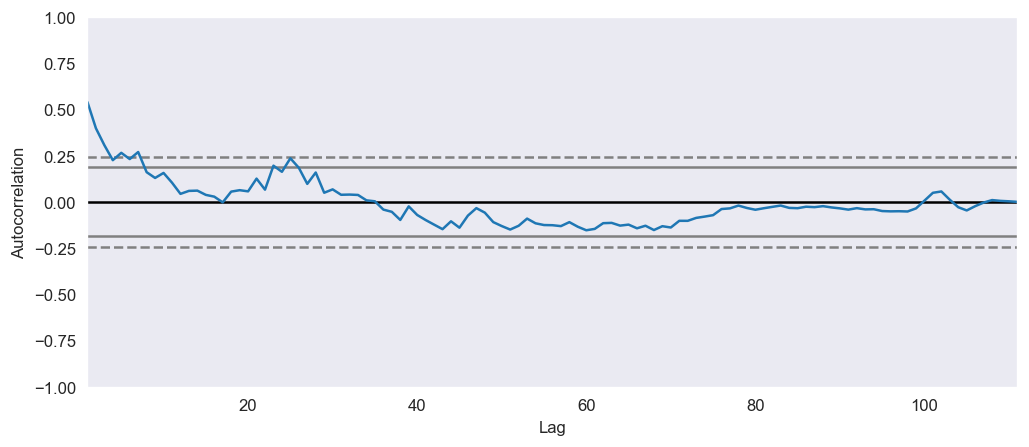

In [56]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(imputed_mice['revenue'].tolist())

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

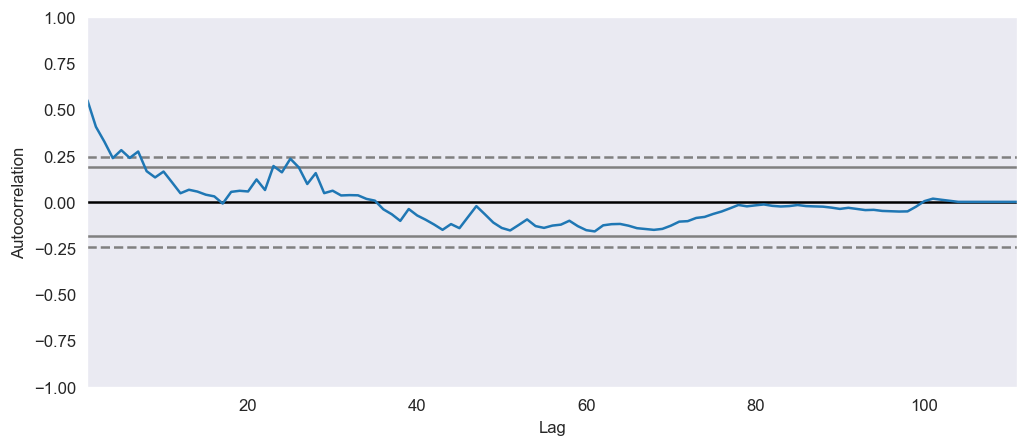

In [57]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(KNN_imputation['revenue'].tolist())

The following tests plot the distribution of the variables in the imputed dataset,
as well as give you the most likely distribution of its parameters. This can be useful
for testing if the distribution is known or comparing against a similar variable whose
distribution as known. It could also be used in creating synthetic data.

In [62]:
temp_df = df.drop(['DATE'], axis=1)
temp_mice = imputed_mice.drop(['DATE'], axis=1)
temp_KNN = KNN_imputation.drop(['DATE'], axis=1)

distributions(temp_df)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 50.75it/s]


revenue
{'gamma': {'a': 0.5266192300869754, 'loc': 303.99999999999994, 'scale': 7738488.51624251}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 57.13it/s]


Paid_Search_S
{'gamma': {'a': 0.7483461482700611, 'loc': 7.999999999999998, 'scale': 19730.004321532382}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 54.04it/s]


social_S
{'gamma': {'a': 0.5392912502933056, 'loc': 530.9999999999999, 'scale': 16937.203607222335}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 57.12it/s]


digital_S
{'cauchy': {'loc': 3411.2454302428305, 'scale': 2815.6358060934335}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 45.66it/s]


Paid_Search_I
{'gamma': {'a': 0.5095903828931176, 'loc': 303.99999999999994, 'scale': 12756380.775643047}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


social_I
{'cauchy': {'loc': 135189.3580821202, 'scale': 117536.83595689986}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 49.74it/s]

digital_I
{'gamma': {'a': 0.634613796171996, 'loc': 9999.999999999998, 'scale': 16668068.853013808}}


In [63]:
distributions(temp_mice)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 51.27it/s]


revenue
{'gamma': {'a': 0.5266192300869754, 'loc': 303.99999999999994, 'scale': 7738488.51624251}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 57.79it/s]


Paid_Search_S
{'gamma': {'a': 0.7483461482700611, 'loc': 7.999999999999998, 'scale': 19730.004321532382}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 55.23it/s]


social_S
{'gamma': {'a': 0.5392912502933056, 'loc': 530.9999999999999, 'scale': 16937.203607222335}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 56.48it/s]


digital_S
{'cauchy': {'loc': 3411.2454302428305, 'scale': 2815.6358060934335}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 47.38it/s]


Paid_Search_I
{'gamma': {'a': 0.5095903828931176, 'loc': 303.99999999999994, 'scale': 12756380.775643047}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 53.47it/s]


social_I
{'cauchy': {'loc': 135189.3580821202, 'scale': 117536.83595689986}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 51.27it/s]

digital_I
{'gamma': {'a': 0.634613796171996, 'loc': 9999.999999999998, 'scale': 16668068.853013808}}


In [64]:
distributions(temp_KNN)

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 51.81it/s]


revenue
{'gamma': {'a': 0.5266192300869754, 'loc': 303.99999999999994, 'scale': 7738488.51624251}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 58.46it/s]


Paid_Search_S
{'gamma': {'a': 0.7483461482700611, 'loc': 7.999999999999998, 'scale': 19730.004321532382}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 55.86it/s]


social_S
{'gamma': {'a': 0.5392912502933056, 'loc': 530.9999999999999, 'scale': 16937.203607222335}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 58.47it/s]


digital_S
{'cauchy': {'loc': 3411.2454302428305, 'scale': 2815.6358060934335}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 48.30it/s]


Paid_Search_I
{'gamma': {'a': 0.5095903828931176, 'loc': 303.99999999999994, 'scale': 12756380.775643047}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 55.24it/s]


social_I
{'cauchy': {'loc': 135189.3580821202, 'scale': 117536.83595689986}}


Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 52.89it/s]

digital_I
{'gamma': {'a': 0.634613796171996, 'loc': 9999.999999999998, 'scale': 16668068.853013808}}


<AxesSubplot: xlabel='digital_S', ylabel='Density'>

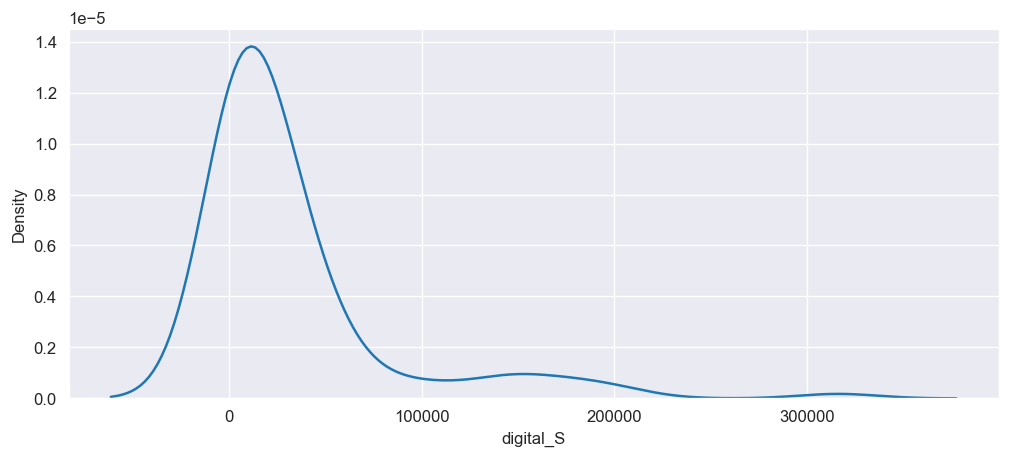

In [76]:
sns.kdeplot(data=KNN_imputation['digital_S'])

<AxesSubplot: xlabel='Paid_Search_I', ylabel='Density'>

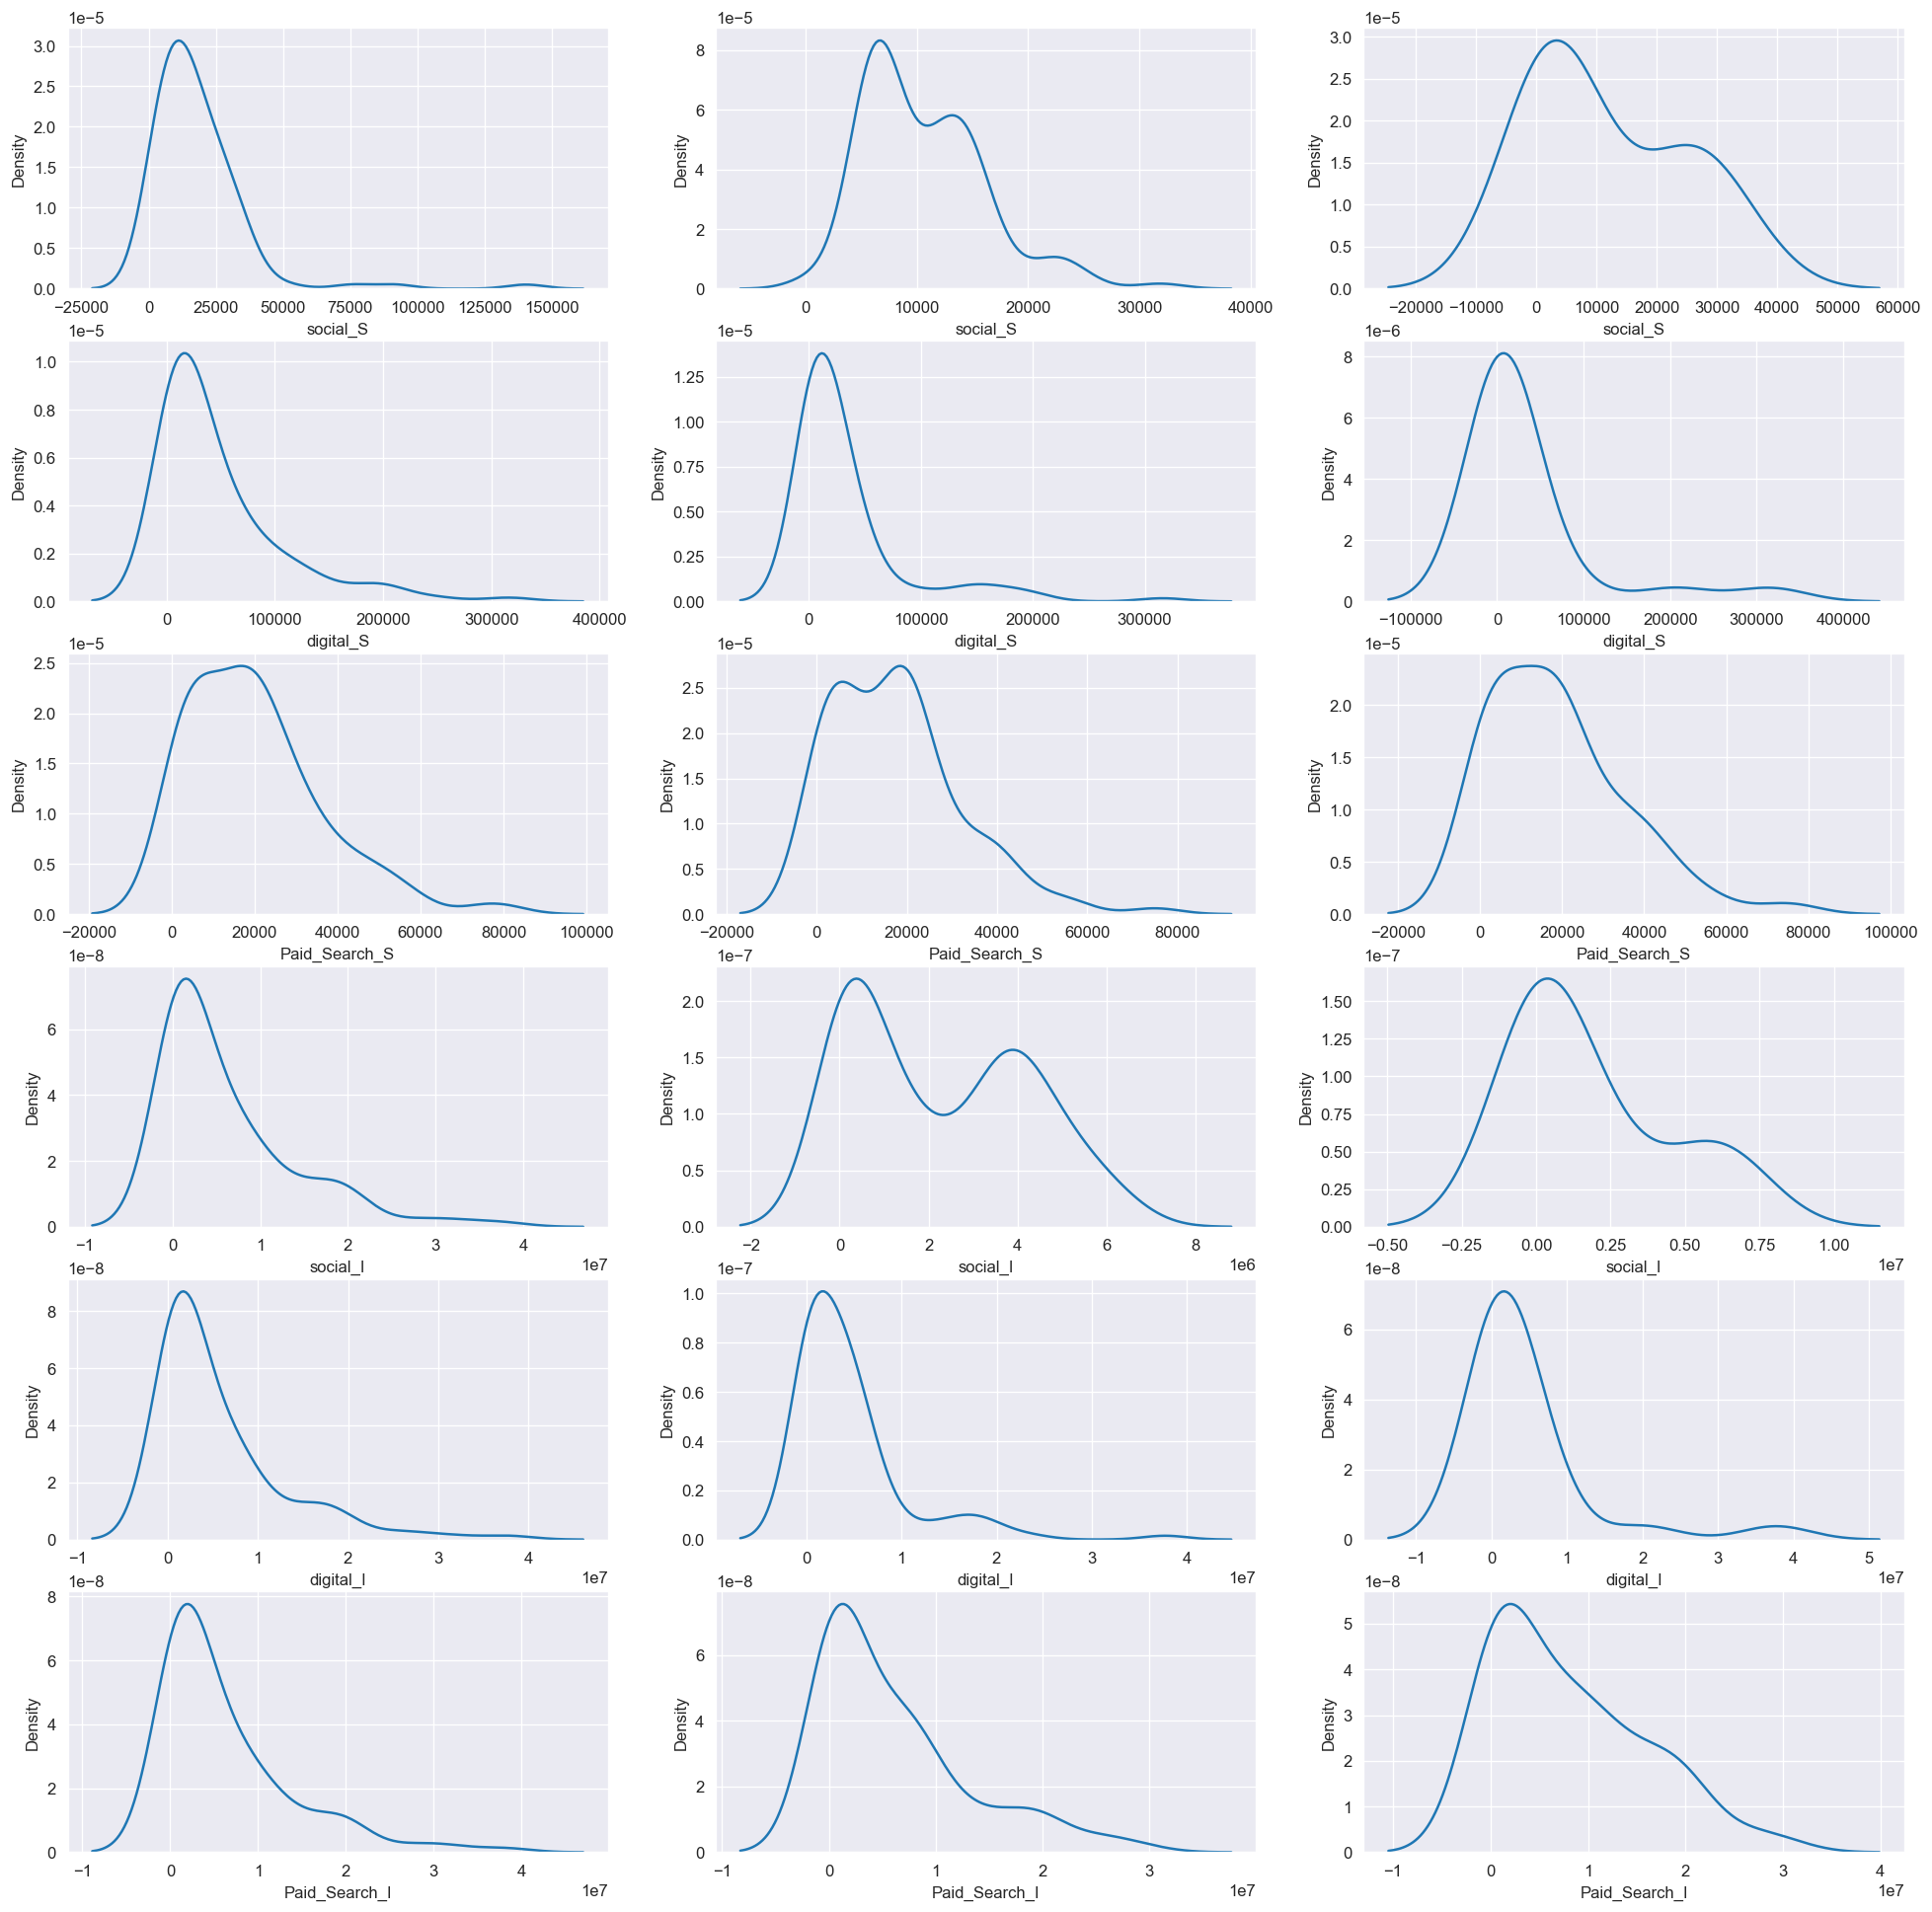

In [113]:
figure, axes = plt.subplots(6, 3, figsize=(20, 20))

sns.kdeplot(ax=axes[0, 0], x='social_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[0, 1], x='social_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[0, 2], x='social_S', data=df, legend=True)
sns.kdeplot(ax=axes[1, 0], x='digital_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[1, 1], x='digital_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[1, 2], x='digital_S', data=df, legend=True)
sns.kdeplot(ax=axes[2, 0], x='Paid_Search_S', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[2, 1], x='Paid_Search_S', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[2, 2], x='Paid_Search_S', data=df, legend=True)
sns.kdeplot(ax=axes[3, 0], x='social_I', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[3, 1], x='social_I', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[3, 2], x='social_I', data=df, legend=True)
sns.kdeplot(ax=axes[4, 0], x='digital_I', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[4, 1], x='digital_I', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[4, 2], x='digital_I', data=df, legend=True)
sns.kdeplot(ax=axes[5, 0], x='Paid_Search_I', data=imputed_mice, legend=True)
sns.kdeplot(ax=axes[5, 1], x='Paid_Search_I', data=KNN_imputation, legend=True)
sns.kdeplot(ax=axes[5, 2], x='Paid_Search_I', data=df, legend=True)

               Count Missing  Percent Missing
revenue                    0              0.0
Paid_Search_S              0              0.0
social_S                   0              0.0
digital_S                  0              0.0
Paid_Search_I              0              0.0
social_I                   0              0.0
digital_I                  0              0.0
DATE                       0              0.0
None
               Count Unique  Percent Unique
revenue                 110            99.1
Paid_Search_S           111           100.0
social_S                111           100.0
digital_S               111           100.0
Paid_Search_I           111           100.0
social_I                111           100.0
digital_I               111           100.0
DATE                    111           100.0
None


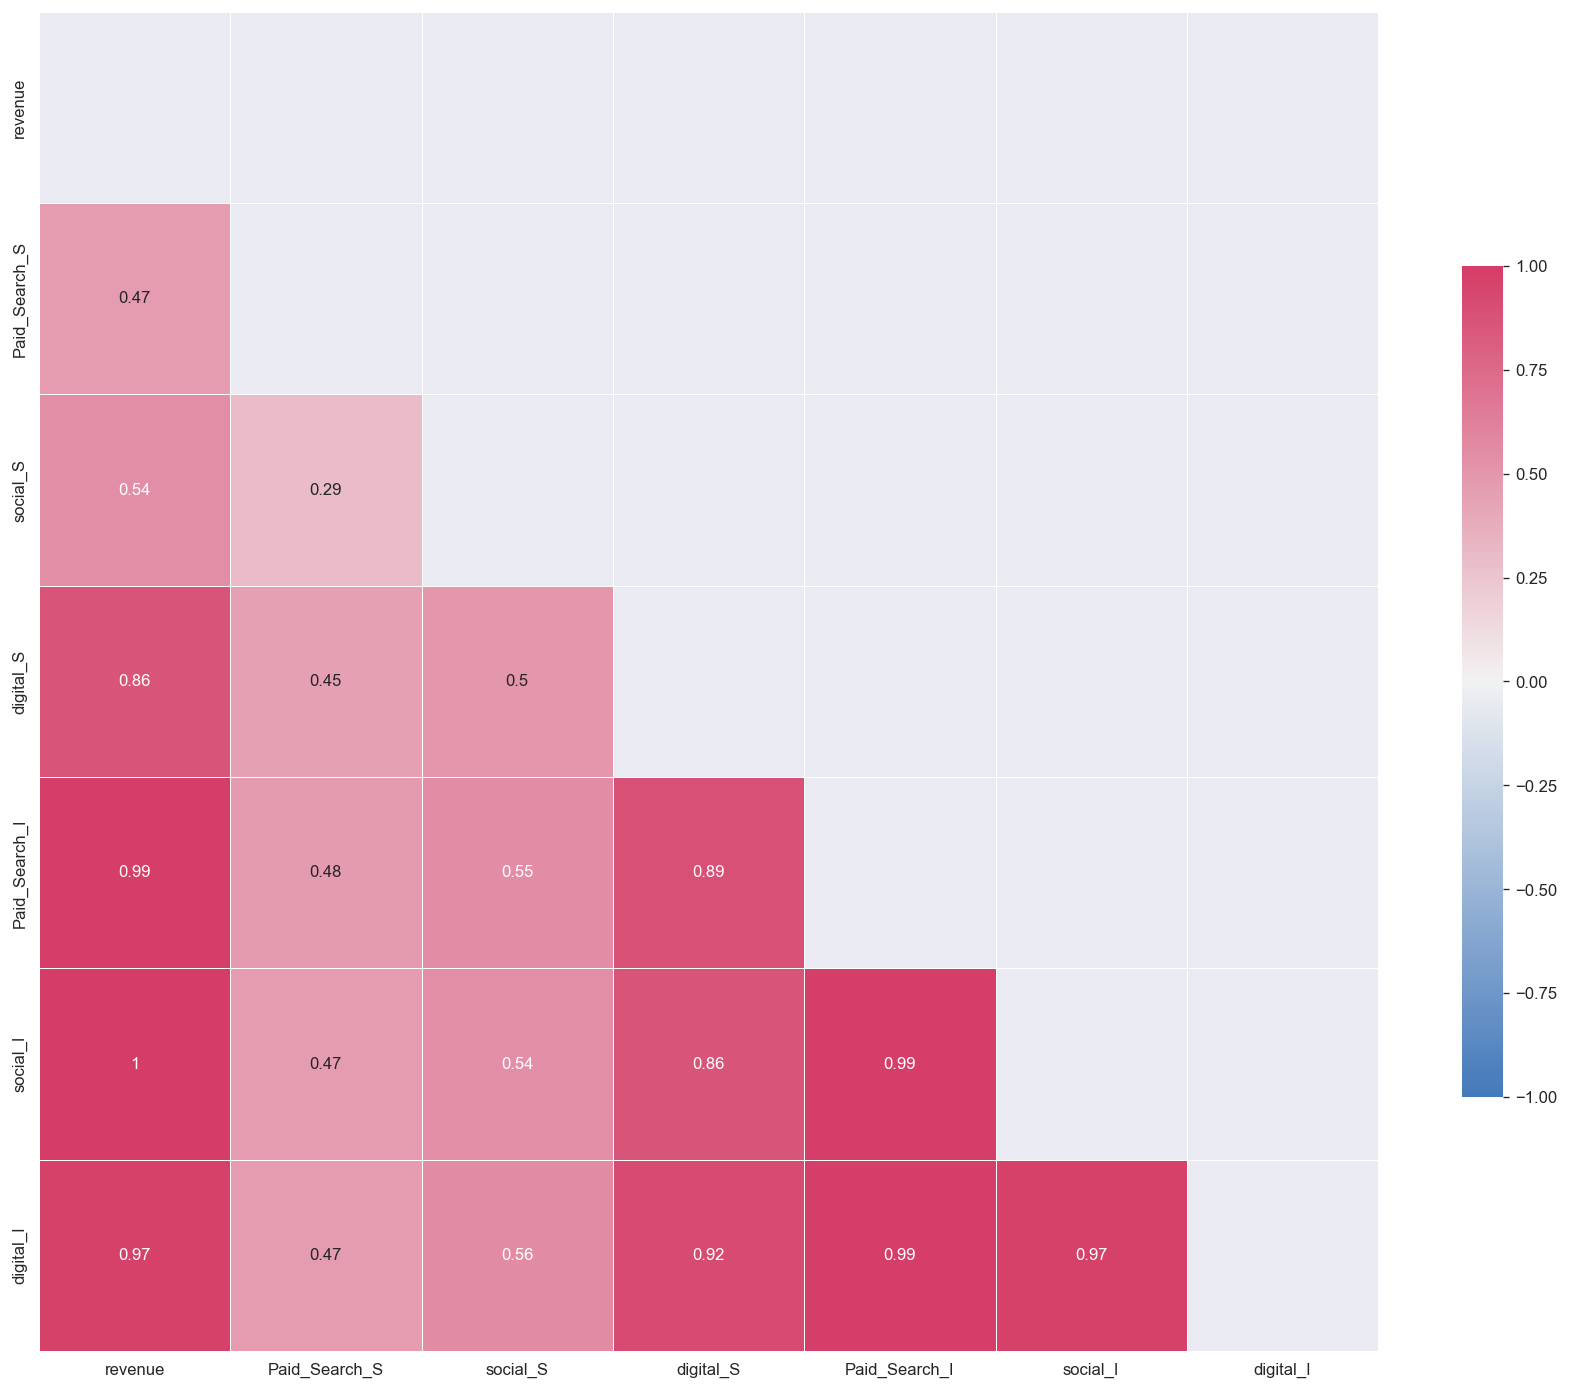

In [114]:
summary(imputed_mice)

               Count Missing  Percent Missing
revenue                    0              0.0
Paid_Search_S              0              0.0
social_S                   0              0.0
digital_S                  0              0.0
Paid_Search_I              0              0.0
social_I                   0              0.0
digital_I                  0              0.0
DATE                       0              0.0
None
               Count Unique  Percent Unique
revenue                 103           92.79
Paid_Search_S           103           92.79
social_S                104           93.69
digital_S               104           93.69
Paid_Search_I           103           92.79
social_I                104           93.69
digital_I               104           93.69
DATE                    111          100.00
None


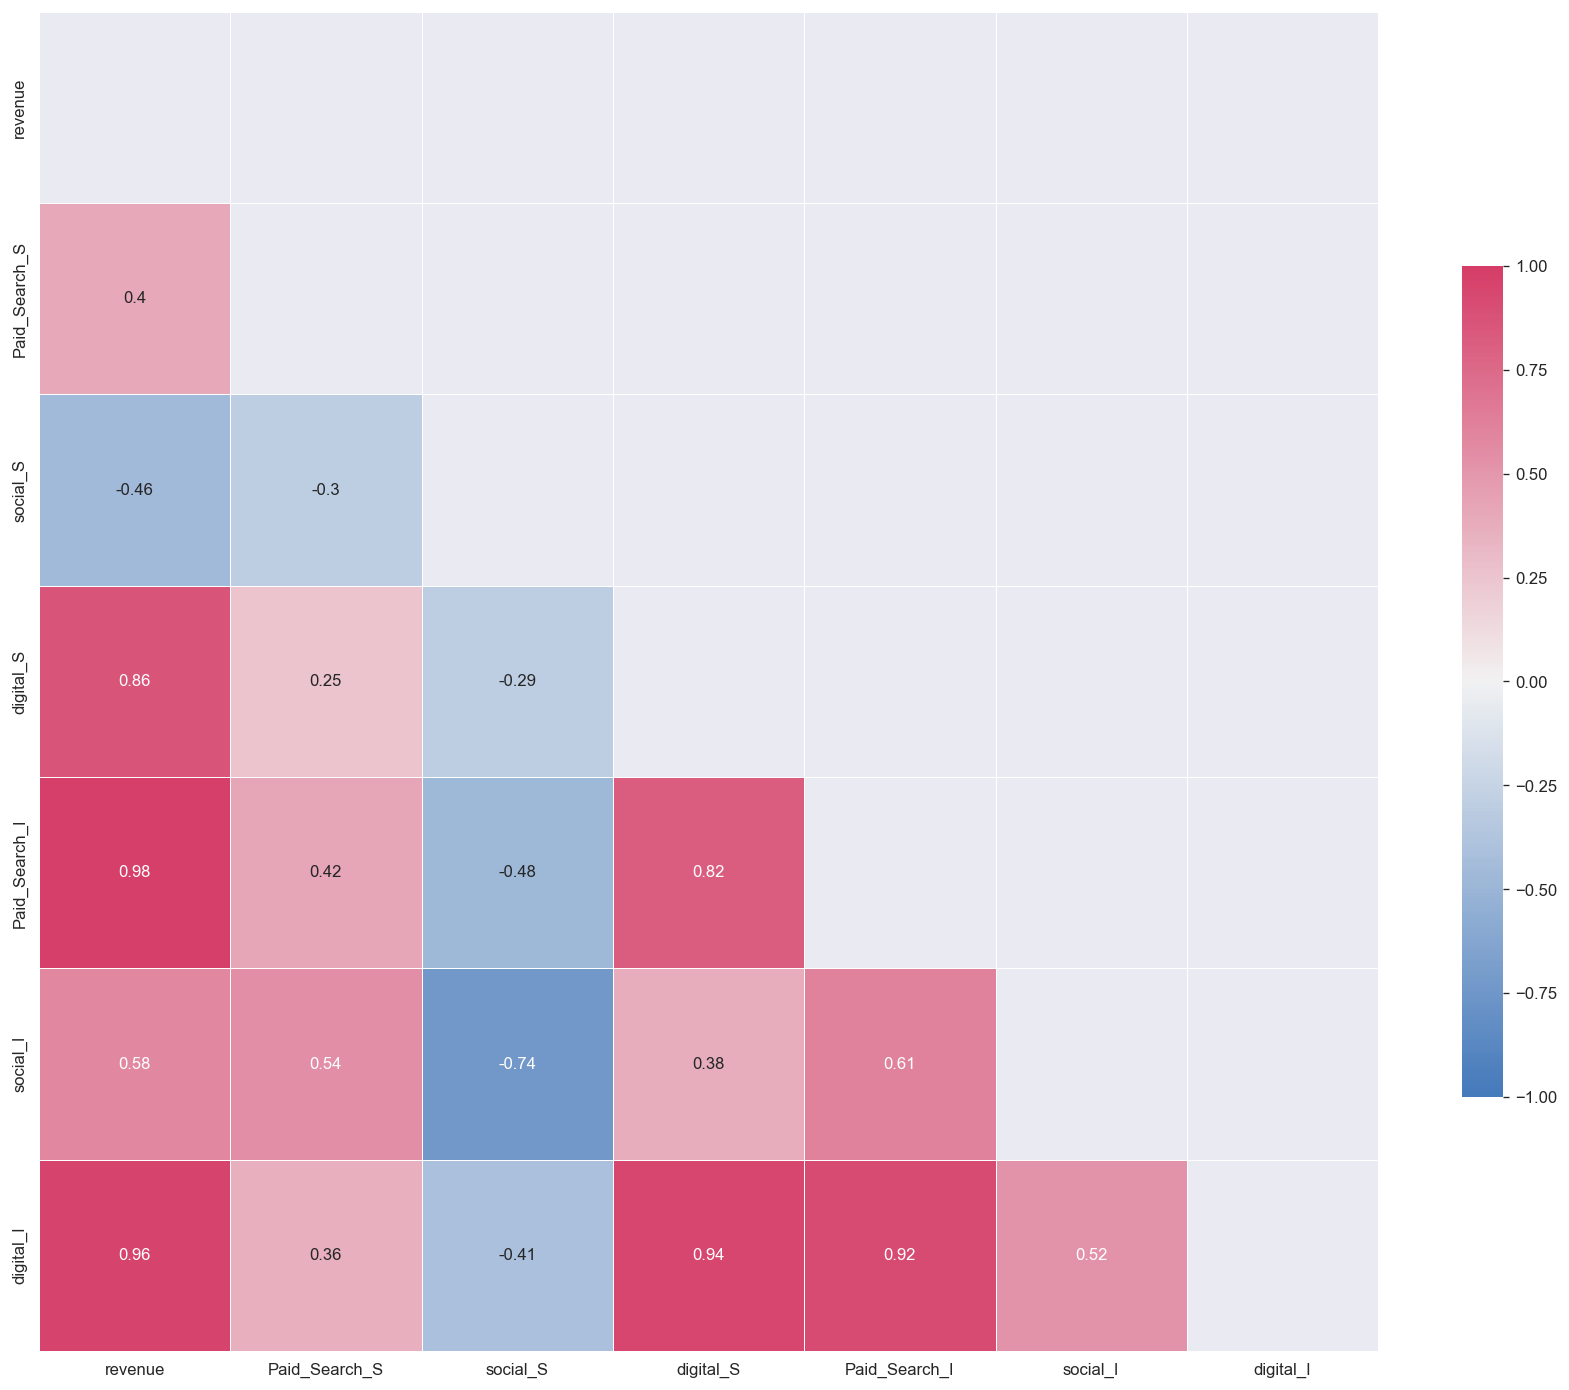

In [115]:
summary(KNN_imputation)